In [1]:

# Import required Libaries
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import numpy as np
# normalization of data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV
from matplotlib import pyplot  as plt

## Read Dataset

In [3]:
# Load the Datasets
df_train=pd.read_csv("aps_failure_training_set.csv",skiprows=20)
df_test=pd.read_csv("aps_failure_test_set.csv",skiprows=20)

In [4]:
# replace the class col from from categorical to binary numerical form
df_test["class"]=df_test["class"].replace({"neg":0,"pos":1})
df_train["class"]=df_train["class"].replace({"neg":0,"pos":1})

In [5]:
# replace np with NAN
df_train.replace({"na":np.NAN},inplace=True)
df_test.replace({"na":np.NAN},inplace=True)

In [6]:
# change column datatype from object to float
df_train=df_train.astype(float)
df_test=df_test.astype(float)

In [7]:
# drop the null values and save to new frame df_tr_null
df_tr_null=df_train.dropna()
df_test_null=df_test.dropna()

In [8]:
# Prepare the data inot X and y
df_tr_x=df_tr_null.drop("class",axis=1)
df_tr_y=df_tr_null["class"]


testx=df_test_null.drop("class",axis=1)
testy=df_test_null["class"]


# Normalization

In [9]:
Normalize=preprocessing.StandardScaler()

In [10]:
df_tr_x=pd.DataFrame(Normalize.fit_transform(df_tr_x))
testx=pd.DataFrame(Normalize.fit_transform(testx))

In [11]:
print(df_tr_x.shape)

(591, 170)


In [12]:
# K_fold method
k_fold=StratifiedKFold(n_splits=5,shuffle=True)

# Here we will dicuss the implemtation of Deep Learning using dataset the droped null values (without replacing it). In later part we will dicuss the base machine learning models and deep learning implemetation using dataset which is Median Imputated.

# Define the fucntion to plot the graphs

In [38]:

def compare_val_loss(dataframe1,dataframe2):
    plt.plot(dataframe1['epochs'][10:],dataframe1["val_loss"][10:], "b--", linewidth=2, label="base_model validation_loss")
    plt.plot(dataframe1['epochs'][10:],dataframe1["loss"][10:], "g-.", linewidth=2, label="base_model training_loss")
    plt.plot(dataframe2['epochs'][10:],dataframe2["val_loss"][10:], "r--", linewidth=2, label="high_model validation_loss")
    plt.plot(dataframe2['epochs'][10:],dataframe2["loss"][10:], "y-.", linewidth=2, label="high_model training_loss")
    plt.title("Validation loss and Training loss comparison")
    plt.xlabel("epochs")
    plt.ylabel("Validation_loss")
    plt.legend()
    plt.plot()



In [39]:
# plo the accuracy of model
def compare_accuracy_curve(dataframe1,dataframe2):
    plt.plot(dataframe1['epochs'][10:],dataframe1["val_accuracy"][10:], "k--", linewidth=2, label="base_model val_accuracy")
    plt.plot(dataframe1['epochs'][10:],dataframe1["accuracy"][10:], "g-.", linewidth=2, label="base_model training_accuracy")
    plt.plot(dataframe2['epochs'][10:],dataframe2["val_accuracy"][10:], "r--", linewidth=2, label="high_model val_accuracy")
    plt.plot(dataframe2['epochs'][10:],dataframe2["accuracy"][10:], "b-.", linewidth=2, label="high_model training_accuracy")
    plt.title("Validation accuracy and Training accuracy calculation")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.plot()

# Build Different Neural Network using the dataset (dropped null values and without PCA)


Model can be develope easy using different layers. what makes different is bulding the efficient model.

B_model neural netwrok build using the Dense layers, relu and sigmoid function as the problem is binary classification.

BN_model: with Dense layer followed by the batchnormlization to normalize the output of layer and dropout to drop some neurons from the layers.

__What is the Neural Network?__

![Getting Started](NN.png)

It is arangement of neuron in the different layers, along with different parameter which could help to improve the performace of the neural network.

Different parameter added to the NN.

1. __Activation Function__: relu, leakyrelu, elu, sigmoid, softmax

![Getting Started](activation2.png)

![Getting Started](activation1.png)

2. __loss fucntion function__
    --for classification: Binary Cross-Entropy, Categorical Cross-Entropy

    --for regression Mean Squared Error, Mean Absolute Error

3. __Dropout layer__: to avoid the over fitting some of the neuraon are deactivated.

4. __Batch Normalization__: the normalization which is been done to have all weights/output of neurons on the same range so that vanishing gradient doesn't happen. When model is overfitting or doesn't improving the performace than we add the Initalizer and Batchnormalization.

5. __Adding the regularization term__: In alst point we ahve dicussed about the initializer and Batchnormalization, if performance do not improve upon adding these terms to layers. Then the regularization term is used in the layers.

    We have studied two types of regularization:
    
        1. __L1 Regularization__: Regularization Term * |weights| doens't consider the all the weights.

        2.__L2 Regularization__: Ridge Regularization which consider all the weights. regularization term * |weights^2|


In [17]:
def B_model():
    model = models.Sequential()
    model.add(layers.Dense(60, input_shape=(170,), activation='relu'))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    
def BN_model():
    model=models.Sequential()
    model.add(layers.Dense(60, input_shape=(170,), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(30,activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    # compile the model
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model




In [18]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(df_tr_x,df_tr_y):
    
    train_x_fold, x_cv_fold = df_tr_x.iloc[train_index,:], df_tr_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = df_tr_y.iloc[train_index], df_tr_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    base_model=B_model()
    high_model=BN_model()

    
    history1=base_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=high_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)

# save the history in dataframe
df1=pd.DataFrame(history1.history)
df1["epochs"]=history1.epoch


df_BN=pd.DataFrame(history2.history)
df_BN["epochs"]=history2.epoch


#save model weights
base_model.save("B_model.h5")
high_model.save("BN_model.h5")

    

In [20]:
# predcition on the test data with 0.5 as threshold 
predict_base=base_model.predict(testx)
predict_base=predict_base>0.5
predict_base_BN=high_model.predict(testx)
predict_base_BN=predict_base_BN>0.5

6/6 [==============================] - 0s 1ms/step


In [21]:
# print the classification report and it for B_model
print(classification_report(testy,predict_base))



              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       135
         1.0       1.00      0.77      0.87        30

    accuracy                           0.96       165
   macro avg       0.98      0.88      0.92       165
weighted avg       0.96      0.96      0.96       165



In [22]:
# classification report for the model BN_model
print(classification_report(testy,predict_base_BN))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       135
         1.0       0.90      0.87      0.88        30

    accuracy                           0.96       165
   macro avg       0.93      0.92      0.93       165
weighted avg       0.96      0.96      0.96       165



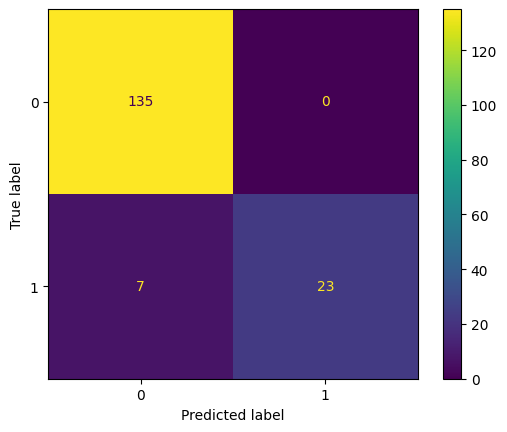

In [24]:
# confusion matrix for the B_model/base model
cm=confusion_matrix(testy,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

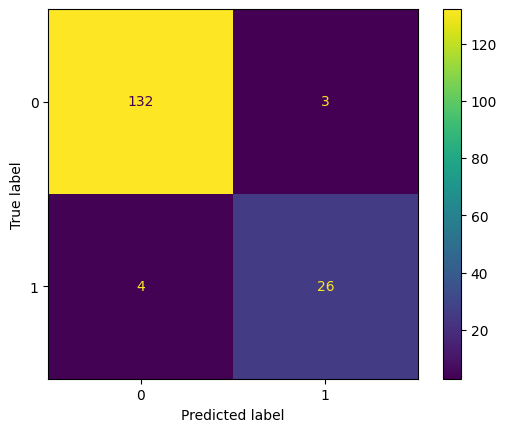

In [25]:
# confusion matrix for the BN_model/high model
cm=confusion_matrix(testy,predict_base_BN)
disp_=ConfusionMatrixDisplay(cm)
disp_.plot()

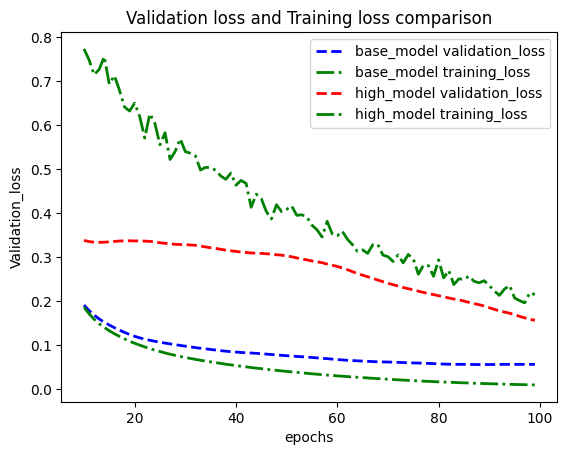

In [39]:

compare_val_loss(df1,df_BN)

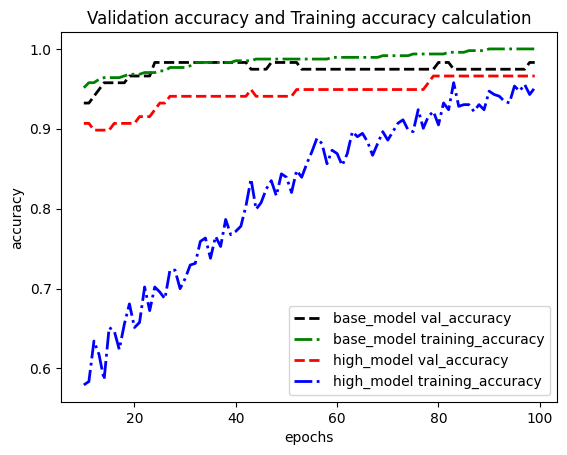

In [40]:
compare_accuracy_curve(df1,df_BN)


>>>Base Model has good perfromace when we apply the deep learning on the data which is not imputated.

# Use Initializer, regularizer and BatchNormalization

In [42]:
def Model_R():
    model = models.Sequential()
    model.add(layers.Dense(60,kernel_initializer="uniform",kernel_regularizer=regularizers.l1(0.01), input_shape=(170,), activation='relu'))
    model.add(layers.Dense(30, activation='relu',kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    
def Model_BR():
    model=models.Sequential()
    model.add(layers.Dense(60,kernel_initializer="uniform",kernel_regularizer=regularizers.l1(0.01), input_shape=(170,), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(30,kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    # compile the model
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model


In [43]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(df_tr_x,df_tr_y):
    
    train_x_fold, x_cv_fold = df_tr_x.iloc[train_index,:], df_tr_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = df_tr_y.iloc[train_index], df_tr_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    base_model=Model_R()
    high_model=Model_BR()

    
    history1=base_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=high_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)


df_R=pd.DataFrame(history1.history)
df_R["epochs"]=history1.epoch


df_BR=pd.DataFrame(history2.history)
df_BR["epochs"]=history2.epoch

In [44]:
# predcition on the test data with 0.5 as threshold 
predict_base=base_model.predict(testx)
predict_base=predict_base>0.5
predict_base_BN=high_model.predict(testx)
predict_base_BN=predict_base_BN>0.5

6/6 [==============================] - 0s 1ms/step


In [45]:
# print the classification report and it for B_model
print(classification_report(testy,predict_base))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       135
         1.0       1.00      0.70      0.82        30

    accuracy                           0.95       165
   macro avg       0.97      0.85      0.90       165
weighted avg       0.95      0.95      0.94       165



In [46]:
# classification report for the model BN_model
print(classification_report(testy,predict_base_BN))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       135
         1.0       1.00      0.10      0.18        30

    accuracy                           0.84       165
   macro avg       0.92      0.55      0.55       165
weighted avg       0.86      0.84      0.78       165



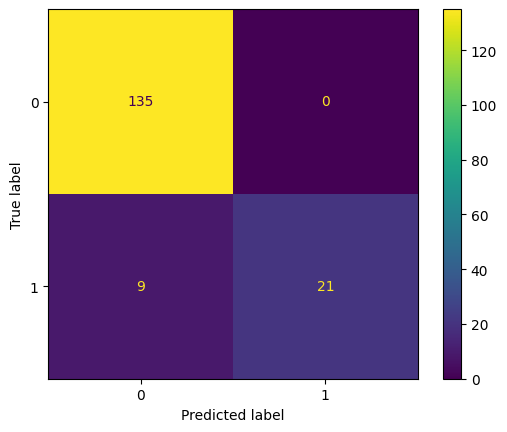

In [47]:
# confusion matrix for the B_model
cm=confusion_matrix(testy,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

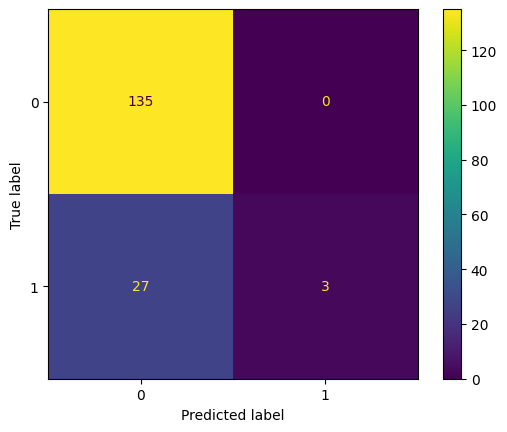

In [48]:
# confusion matrix for the BN_model
cm=confusion_matrix(testy,predict_base_BN)
disp_=ConfusionMatrixDisplay(cm)
disp_.plot()

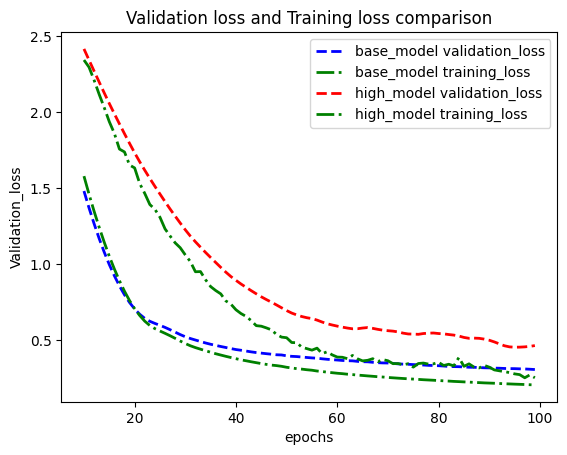

In [52]:

compare_val_loss(df_R,df_BR)

We can see the effect of adding the different parameters such as initializer, regularizer to the model. the validation loss curves are much soften.

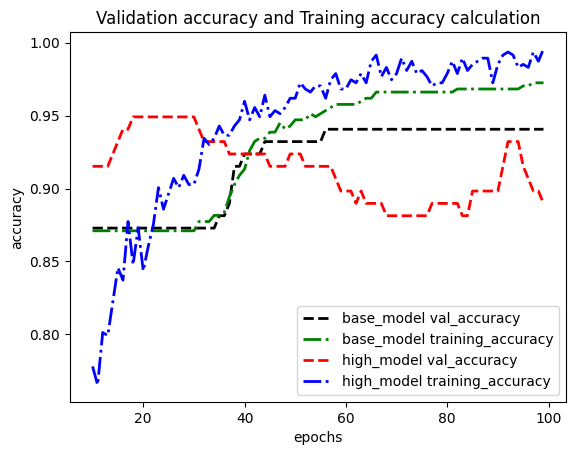

In [53]:
compare_accuracy_curve(df_R,df_BR)

The model which is simple which is simple Model_R has show the good accuracy. but if we compare the Model_R and model_B performace considering the classification report, and curves we can say that they are performing very close to each other.

# Comment on above models


Base model and High Model
Looking at the validation loss and training loss curve, also validation_accuracy and traininng accuarcy vs epochs. Both of the model has shown efficient performance.

The base model has high accuarcy as well as the high f1-score so that could be the best model to use.


## Try different model with 

In [70]:

def model1():

    model=models.Sequential()
    model.add(layers.Dense(128,activation="relu",input_shape=(df_tr_x.shape[1],)))

    model.add(layers.Dense(118,activation="relu"))

    model.add(layers.Dense(64,activation="relu"))

    model.add(layers.Dense(32,activation="relu"))

    model.add(layers.Dense(1,activation="sigmoid"))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def model2():

    model=models.Sequential()
    model.add(layers.Dense(128,activation="elu",input_shape=(df_tr_x.shape[1],)))

    model.add(layers.Dense(118,activation="elu"))

    model.add(layers.Dense(64,activation="elu"))

    model.add(layers.Dense(32,activation="elu"))

    model.add(layers.Dense(1,activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [71]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(df_tr_x,df_tr_y):
    
    train_x_fold, x_cv_fold = df_tr_x.iloc[train_index,:], df_tr_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = df_tr_y.iloc[train_index], df_tr_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    base_model=model1()
    high_model=model2()

    
    history1=base_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=high_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)


df_rms=pd.DataFrame(history1.history)
df_rms["epochs"]=history1.epoch


df_adam=pd.DataFrame(history2.history)
df_adam["epochs"]=history2.epoch
    

In [72]:
# predcition on the test data
predict_base=base_model.predict(testx)
predict_base=predict_base>0.5
predict_base_BN=high_model.predict(testx)
predict_base_BN=predict_base_BN>0.5

6/6 [==============================] - 0s 2ms/step


In [73]:
# print the classification report and it for B_model
print(classification_report(testy,predict_base))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       135
         1.0       0.96      0.77      0.85        30

    accuracy                           0.95       165
   macro avg       0.95      0.88      0.91       165
weighted avg       0.95      0.95      0.95       165



In [74]:
# classification report for the model BN_model

print(classification_report(testy,predict_base_BN))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       135
         1.0       0.96      0.87      0.91        30

    accuracy                           0.97       165
   macro avg       0.97      0.93      0.95       165
weighted avg       0.97      0.97      0.97       165



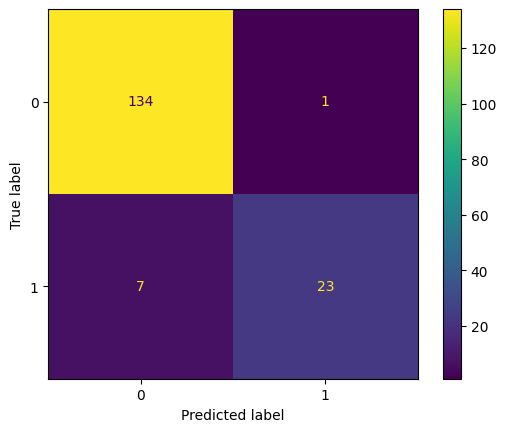

In [75]:
# confusion matrix for the B_model
cm=confusion_matrix(testy,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

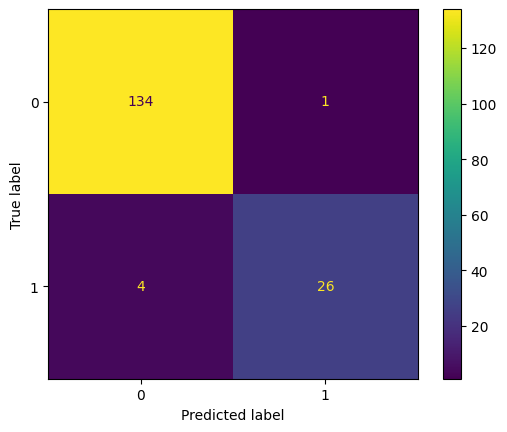

In [76]:
# confusion matrix for the BN_model
cm=confusion_matrix(testy,predict_base_BN)
disp_=ConfusionMatrixDisplay(cm)
disp_.plot()

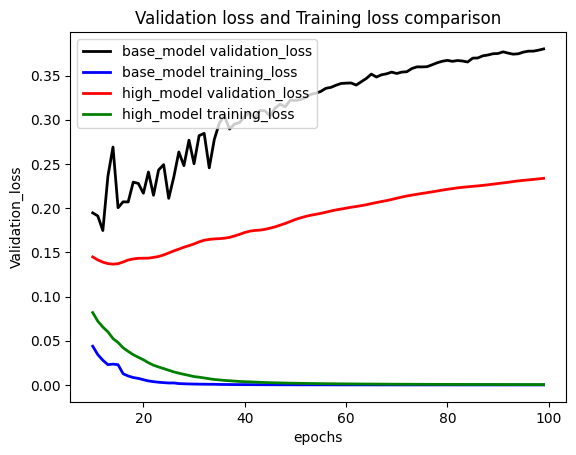

In [78]:

compare_val_loss(df_rms,df_adam)


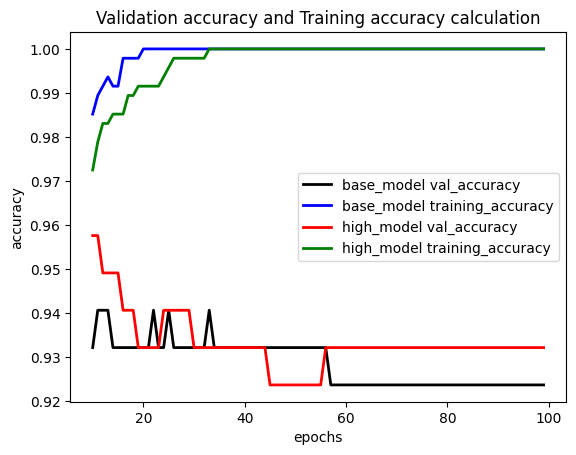

In [79]:

compare_accuracy_curve(df_rms,df_adam)

In [113]:
def model1_rms():

    model=models.Sequential()
    model.add(layers.Dense(128,activation="relu",input_shape=(df_tr_x.shape[1],),kernel_regularizer=regularizers.l1(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(118,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(64,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(32,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1,activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [114]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(df_tr_x,df_tr_y):
    
    train_x_fold, x_cv_fold = df_tr_x.iloc[train_index,:], df_tr_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = df_tr_y.iloc[train_index], df_tr_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    base_model=model1_rms()
   

    
    history1=base_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    


df_rms=pd.DataFrame(history1.history)
df_rms["epochs"]=history1.epoch



In [116]:
# predcition on the test data
predict_base=base_model.predict(testx)
predict_base=predict_base>0.5


6/6 [==============================] - 0s 3ms/step


In [117]:
# classification report for the model BN_model
# print the classification report and it for B_model
print(classification_report(testy,predict_base))


              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       135
         1.0       1.00      0.77      0.87        30

    accuracy                           0.96       165
   macro avg       0.98      0.88      0.92       165
weighted avg       0.96      0.96      0.96       165



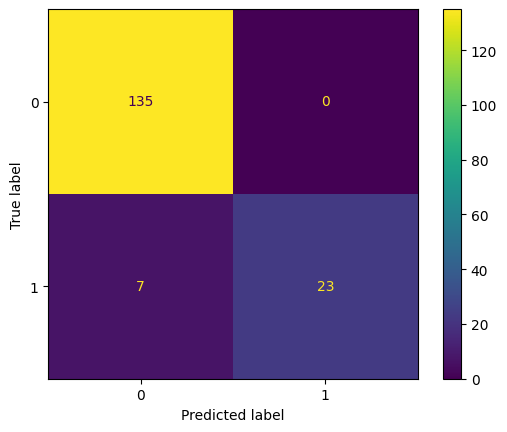

In [118]:
# confusion matrix for the B_model
cm=confusion_matrix(testy,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [122]:

def compare_val_loss1(dataframe1):
    plt.plot(dataframe1['epochs'][10:],dataframe1["val_loss"][10:], "b--", linewidth=2, label="base_model validation_loss")
    plt.plot(dataframe1['epochs'][10:],dataframe1["loss"][10:], "g-.", linewidth=2, label="base_model training_loss")
    plt.title("Validation loss and Training loss comparison")
    plt.xlabel("epochs")
    plt.ylabel("Validation_loss")
    plt.legend()
    plt.plot()

# plo the accuracy of model
def compare_accuracy_curve1(dataframe1):
    plt.plot(dataframe1['epochs'][10:],dataframe1["val_accuracy"][10:], "k--", linewidth=2, label="base_model val_accuracy")
    plt.plot(dataframe1['epochs'][10:],dataframe1["accuracy"][10:], "g-.", linewidth=2, label="base_model training_accuracy")
    plt.title("Validation accuracy and Training accuracy calculation")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.plot()

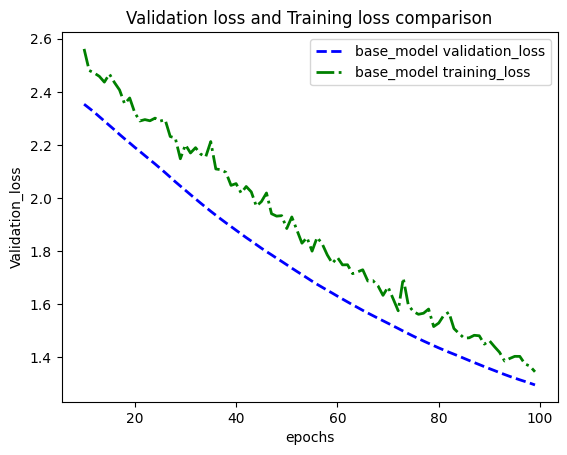

In [120]:

compare_val_loss1(df_rms)


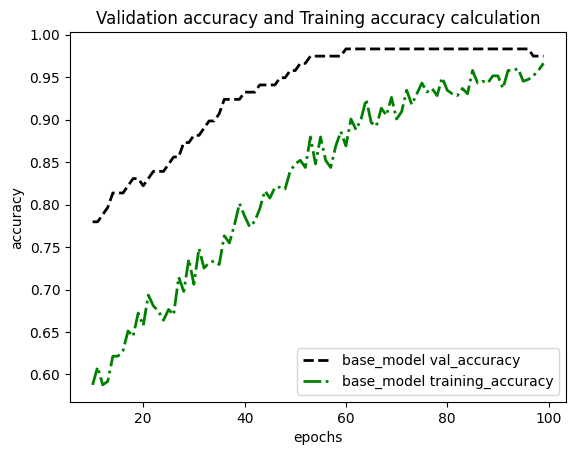

In [123]:

compare_accuracy_curve1(df_rms)

# comment on complex models
Looking at the validation loss and trainining loss, one understand the models is overfitting. although it has shown good performace.

# Third Approach: Median Imputation

In [16]:
data=pd.DataFrame(df_train.isnull().sum().nlargest(7))
data1=pd.DataFrame(df_test.isnull().sum().nlargest(7))

data1.reset_index(inplace=True)
data.reset_index(inplace=True)

In [17]:
df_median_train=df_train.drop(np.asarray(data["index"]),axis=1)
df_median_test=df_test.drop(np.asarray(data1["index"]),axis=1)

In [18]:
# dataframes filled with median values 
df_median_train=df_median_train.fillna(df_median_train.median())
df_median_test=df_median_test.fillna(df_median_test.median())

In [19]:
# split data inot x and y
data_trmedian_x=df_median_train.drop(["class"],axis=1)
data_trmedian_y=df_median_train["class"]

data_temedian_x=df_median_test.drop(["class"],axis=1)
data_temedian_y=df_median_test["class"]

In [20]:
data_trmedian_x=pd.DataFrame(Normalize.fit_transform(data_trmedian_x))
data_temedian_x=pd.DataFrame(Normalize.fit_transform(data_temedian_x))

# Implementation using the Base Model

## Implementation of logistic regression with dataset imputated with median

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,ConfusionMatrixDisplay,accuracy_score,classification_report,precision_recall_curve,average_precision_score,auc,roc_curve

In [22]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state = 2021
solver = 'liblinear' # For small datasets, it is good.
logReg = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver)

In [23]:
trainx,trainy=data_trmedian_x,data_trmedian_y

In [21]:
TotalPredictPro=pd.DataFrame(data=[],index=trainy.index,columns=[0,1])
Score_train=[]
Score_cv=[]
for train_index,cv_index in k_fold.split(trainx,trainy):
    train_x_fold, x_cv_fold = trainx.iloc[train_index,:], trainx.iloc[cv_index,:]
    train_y_fold, y_cv_fold = trainy.iloc[train_index], trainy.iloc[cv_index]

    logReg.fit(train_x_fold,train_y_fold)

    predictpro_tr=logReg.predict_proba(train_x_fold)  # predict_proba is confidence score of detected value be;ongs to perticular class
    entropy_loss_tr=log_loss(train_y_fold,predictpro_tr)
    Score_train.append(entropy_loss_tr)


    predictpro_val=logReg.predict_proba(x_cv_fold)
    entropy_loss_val=log_loss(y_cv_fold,predictpro_val)
    Score_cv.append(entropy_loss_val)


    TotalPredictPro.loc[x_cv_fold.index,:] =logReg.predict_proba(x_cv_fold)


    print("******************************************************")
    print(f"The log_loss on training dataset is { entropy_loss_tr}")
    print(f"The log_loss on training dataset is { entropy_loss_val}")

print("**********************************************")
predicty=logReg.predict_proba(trainx)
total_entropy_loss=log_loss(trainy,predicty)

print(f"Total log_loss given as {total_entropy_loss}")


******************************************************
The log_loss on training dataset is 0.024464146916115204
The log_loss on training dataset is 0.029404641464361926
******************************************************
The log_loss on training dataset is 0.024675091422145266
The log_loss on training dataset is 0.027947321511070565
******************************************************
The log_loss on training dataset is 0.023336023534440167
The log_loss on training dataset is 0.03741096178885223
******************************************************
The log_loss on training dataset is 0.023611938303115997
The log_loss on training dataset is 0.037386713961583676
******************************************************
The log_loss on training dataset is 0.02422819116714291
The log_loss on training dataset is 0.037199852135891845
**********************************************
Total log_loss given as 0.026822523360892702


In [22]:
pred=logReg.predict(data_temedian_x)

In [23]:
# classification report Logistic Regression
print(classification_report(data_temedian_y,pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.90      0.52      0.66       375

    accuracy                           0.99     16000
   macro avg       0.95      0.76      0.83     16000
weighted avg       0.99      0.99      0.99     16000



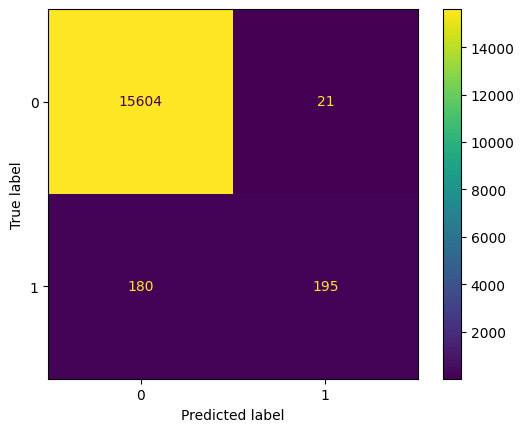

In [24]:
# plot confusion matrix
cm=confusion_matrix(data_temedian_y,pred)
display=ConfusionMatrixDisplay(cm)
display.plot()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.76')

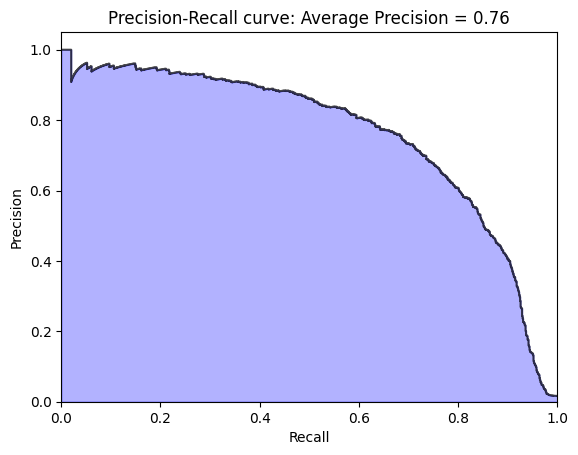

In [25]:
# precision and recall curve


preds = pd.concat([trainy,TotalPredictPro.loc[:,1]], axis=1)  # add two column to create a datafarme
preds.columns = ['trueLabel','prediction']
TotalPredictPro = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

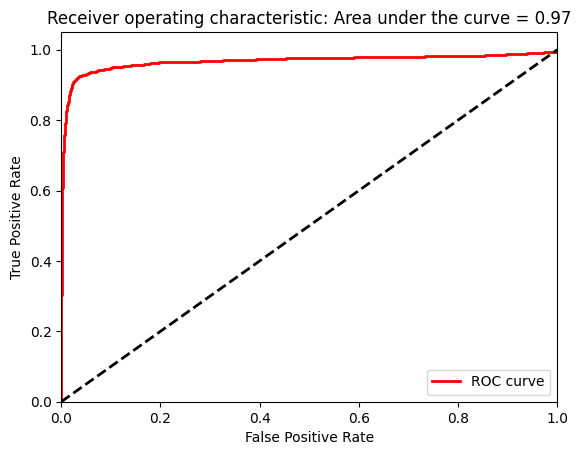

In [26]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

In [28]:
# Number of trees in the forest:
n_estimators = 15
# Number of features to consider when looking for the best split:
max_features="sqrt"
# Maximum depth of the tree:
max_depth = 20
# Minimum number of samples required to split an internal node:
min_samples_split = 3
# Minimum number of samples required to be at a leaf node:
min_samples_leaf = 1
# Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. 
max_leaf_nodes = None
# Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree:
bootstrap = False
# Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
oob_score = False
# Number of jobs to run in parallel. (-1) means use all.
n_jobs = -1
# Random state
random_state = 2020
#-----------------------------------------------------------------
# Creating the classifier:
RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)

In [29]:
model1=RFC

trainScore=[]
valScore=[]
total_prob=pd.DataFrame(data=[],index=trainx.index,columns=[0,1])


for train_index,cv_index in k_fold.split(trainx,trainy):
    train_x_fold, x_cv_fold = trainx.iloc[train_index,:], trainx.iloc[cv_index,:]
    train_y_fold, y_cv_fold = trainy.iloc[train_index], trainy.iloc[cv_index]

    model1.fit(train_x_fold,train_y_fold)
    # let look at prediction probability of being 0(neg) or 1(pos) for training fold
    prob_train=model1.predict_proba(train_x_fold)
    loglosstrain=log_loss(train_y_fold,prob_train)
    trainScore.append(loglosstrain)

    # let look at prediction probability of being 0(neg) or 1(pos) for cv fold
    prob_cv=model1.predict_proba(x_cv_fold)
    loglosscv=log_loss(y_cv_fold,prob_cv)
    valScore.append(loglosscv)


    total_prob.loc[x_cv_fold.index,:]=model1.predict_proba(x_cv_fold)
    
    print("**************************************")
    print(f"Training Log Loss is {loglosstrain}")
    print(f"CV Log Loss is {loglosscv}")

pre_train_y=model1.predict_proba(trainx)
loglosstotal=log_loss(trainy,pre_train_y) 

print("************************************")
print(f"RFC log loss {loglosstotal}")


**************************************
Training Log Loss is 0.0029244177302208112
CV Log Loss is 0.022129822714520363
**************************************
Training Log Loss is 0.0018373338446028983
CV Log Loss is 0.023692150324856925
**************************************
Training Log Loss is 0.0017885258926313057
CV Log Loss is 0.0249803728286486
**************************************
Training Log Loss is 0.0017249260674170237
CV Log Loss is 0.02460981012297468
**************************************
Training Log Loss is 0.0017031844190197093
CV Log Loss is 0.021896772044625295
************************************
RFC log loss 0.00574190194414082


In [31]:
predict_RF=model1.predict(data_temedian_x)

In [32]:
# classification Report Random Forest
print(classification_report(data_temedian_y,predict_RF))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.92      0.66      0.77       375

    accuracy                           0.99     16000
   macro avg       0.96      0.83      0.88     16000
weighted avg       0.99      0.99      0.99     16000



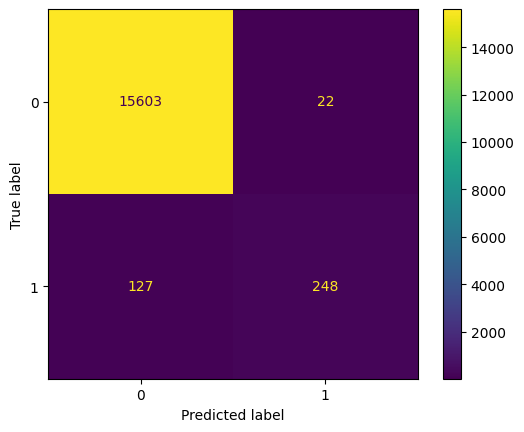

In [34]:

cm=confusion_matrix(data_temedian_y,predict_RF)
dis=ConfusionMatrixDisplay(cm)
dis.plot()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.85')

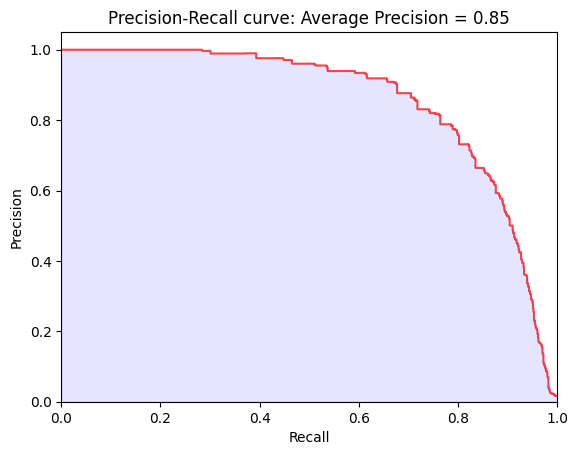

In [35]:
preds = pd.concat([trainy,total_prob.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='r', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.1, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

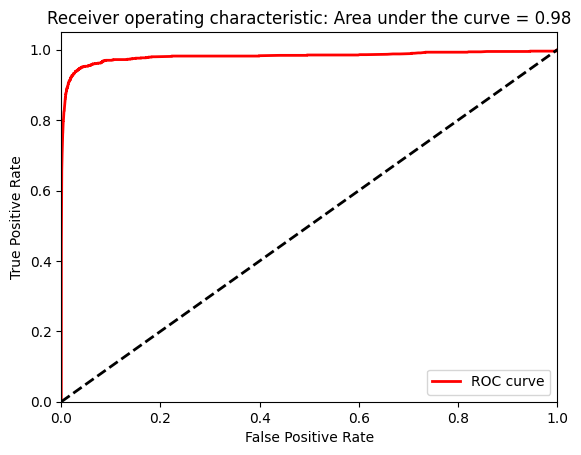

In [36]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# AdaBoost Implementation

In [38]:
# adaboost hyperparameters

n_estimators=20
learning_rate=0.0001
algorithm="SAMME.R"        #{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

adaboost=AdaBoostClassifier(n_estimators=n_estimators,learning_rate=learning_rate,algorithm=algorithm,random_state=2020)

In [39]:
model1=adaboost

trainScore=[]
valScore=[]
TotalPredictPro_ada=pd.DataFrame(data=[],index=trainx.index,columns=[0,1])


for train_index,cv_index in k_fold.split(trainx,trainy):
    train_x_fold, x_cv_fold = trainx.iloc[train_index,:], trainx.iloc[cv_index,:]
    train_y_fold, y_cv_fold = trainy.iloc[train_index], trainy.iloc[cv_index]

    model1.fit(train_x_fold,train_y_fold)
    # let look at prediction probability of being 0(neg) or 1(pos) for training fold
    prob_train=model1.predict_proba(train_x_fold)
    loglosstrain=log_loss(train_y_fold,prob_train)
    trainScore.append(loglosstrain)

    # let look at prediction probability of being 0(neg) or 1(pos) for cv fold
    prob_cv=model1.predict_proba(x_cv_fold)
    loglosscv=log_loss(y_cv_fold,prob_cv)
    valScore.append(loglosscv)


    TotalPredictPro_ada.loc[x_cv_fold.index,:]=model1.predict_proba(x_cv_fold)
    
    print("**************************************")
    print(f"Training Log Loss is {loglosstrain}")
    print(f"CV Log Loss is {loglosscv}")

pre_train_y=model1.predict_proba(trainx)
loglosstotal=log_loss(trainy,pre_train_y) 

print("************************************")
print(f"RFC log loss {loglosstotal}")


**************************************
Training Log Loss is 0.04736297346749011
CV Log Loss is 0.0495364065101294
**************************************
Training Log Loss is 0.04910820867784961
CV Log Loss is 0.04710728080505792
**************************************
Training Log Loss is 0.047556690794146754
CV Log Loss is 0.04915480576303495
**************************************
Training Log Loss is 0.04849335588330366
CV Log Loss is 0.05013478657072737
**************************************
Training Log Loss is 0.04788011320813812
CV Log Loss is 0.04831557789233027
************************************
RFC log loss 0.04796720614497656


In [44]:
predict_ad=model1.predict(data_temedian_x)

In [45]:
print(classification_report(data_temedian_y,predict_ad))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     15625
         1.0       0.00      0.00      0.00       375

    accuracy                           0.98     16000
   macro avg       0.49      0.50      0.49     16000
weighted avg       0.95      0.98      0.96     16000



C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


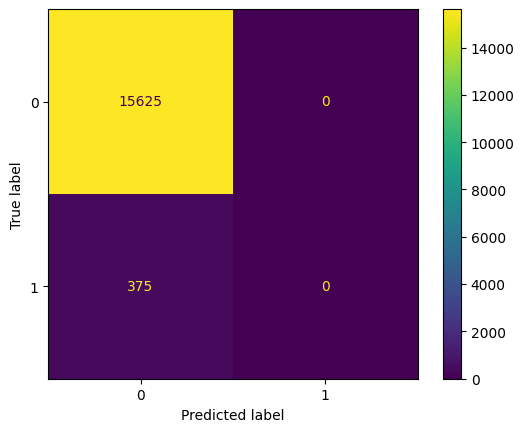

In [46]:
cm=confusion_matrix(data_temedian_y,predict_ad)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.30')

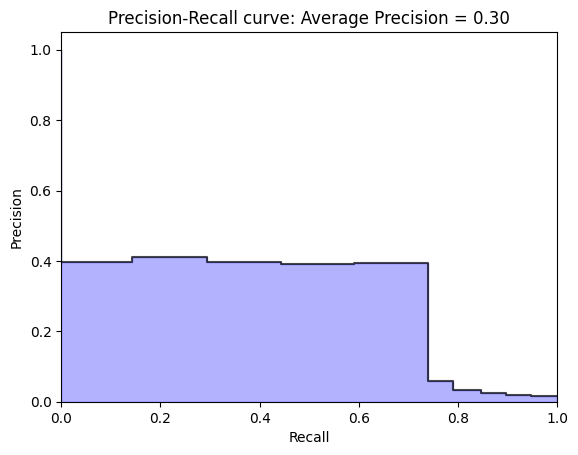

In [47]:
# precision and recall curve


preds_ada = pd.concat([trainy,TotalPredictPro_ada.loc[:,1]], axis=1)  # add two column to create a datafarme
preds_ada.columns = ['trueLabel','prediction']
TotalPredictPro_ada = preds_ada.copy()
precision, recall, thresholds = precision_recall_curve(preds_ada['trueLabel'],preds_ada['prediction'])
average_precision = average_precision_score(preds_ada['trueLabel'],preds_ada['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

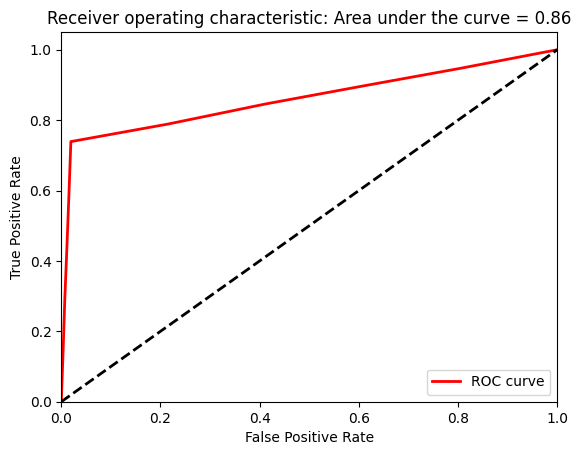

In [48]:
fpr, tpr, thresholds = roc_curve(preds_ada['trueLabel'],preds_ada['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Improved Adaboost Implementation

In [57]:
# adaboost hyperparameters

n_estimators=60
learning_rate=1 
algorithm="SAMME.R"        #{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’


adaboost=AdaBoostClassifier(n_estimators=n_estimators,learning_rate=learning_rate,algorithm=algorithm,random_state=2020)

In [58]:
model1=adaboost

trainScore=[]
valScore=[]
TotalPredictPro_ada=pd.DataFrame(data=[],index=trainx.index,columns=[0,1])


for train_index,cv_index in k_fold.split(trainx,trainy):
    train_x_fold, x_cv_fold = trainx.iloc[train_index,:], trainx.iloc[cv_index,:]
    train_y_fold, y_cv_fold = trainy.iloc[train_index], trainy.iloc[cv_index]

    model1.fit(train_x_fold,train_y_fold)
    # let look at prediction probability of being 0(neg) or 1(pos) for training fold
    prob_train=model1.predict_proba(train_x_fold)
    loglosstrain=log_loss(train_y_fold,prob_train)
    trainScore.append(loglosstrain)

    # let look at prediction probability of being 0(neg) or 1(pos) for cv fold
    prob_cv=model1.predict_proba(x_cv_fold)
    loglosscv=log_loss(y_cv_fold,prob_cv)
    valScore.append(loglosscv)


    TotalPredictPro_ada.loc[x_cv_fold.index,:]=model1.predict_proba(x_cv_fold)
    
    print("**************************************")
    print(f"Training Log Loss is {loglosstrain}")
    print(f"CV Log Loss is {loglosscv}")

pre_train_y=model1.predict_proba(trainx)
adaboostlosstotal=log_loss(trainy,pre_train_y) 

print("************************************")
print(f"RFC log loss {adaboostlosstotal}")


**************************************
Training Log Loss is 0.5903994347089068
CV Log Loss is 0.589390379226267
**************************************
Training Log Loss is 0.5745122317626653
CV Log Loss is 0.5757413570490245
**************************************
Training Log Loss is 0.587435942838918
CV Log Loss is 0.5869284568531817
**************************************
Training Log Loss is 0.608792770428496
CV Log Loss is 0.609077419914474
**************************************
Training Log Loss is 0.5882656603471904
CV Log Loss is 0.5883696706612123
************************************
RFC log loss 0.5882864624099949


In [59]:
predict_ad=model1.predict(data_temedian_x)

In [60]:
# Calssification report adaboost
print(classification_report(data_temedian_y,predict_ad))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.84      0.57      0.68       375

    accuracy                           0.99     16000
   macro avg       0.92      0.79      0.84     16000
weighted avg       0.99      0.99      0.99     16000



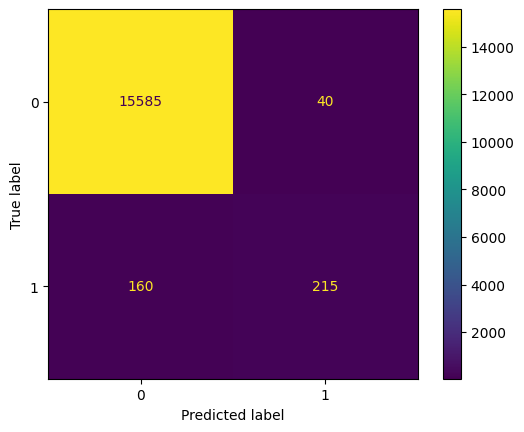

In [61]:
# plot the confusion matrix
cm=confusion_matrix(data_temedian_y,predict_ad)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.81')

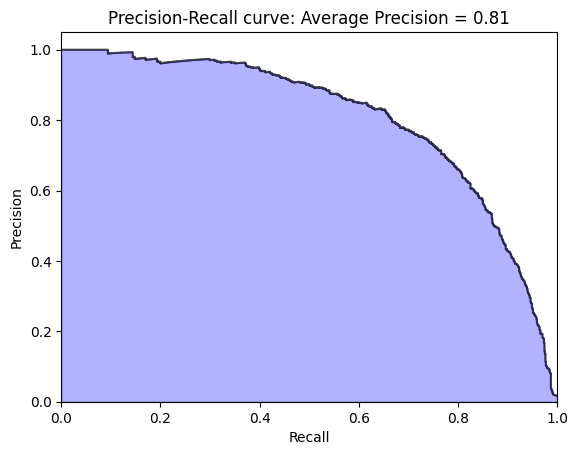

In [55]:
# precision and recall curve


preds_ada = pd.concat([trainy,TotalPredictPro_ada.loc[:,1]], axis=1)  # add two column to create a datafarme
preds_ada.columns = ['trueLabel','prediction']
TotalPredictPro_ada = preds_ada.copy()
precision, recall, thresholds = precision_recall_curve(preds_ada['trueLabel'],preds_ada['prediction'])
average_precision = average_precision_score(preds_ada['trueLabel'],preds_ada['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

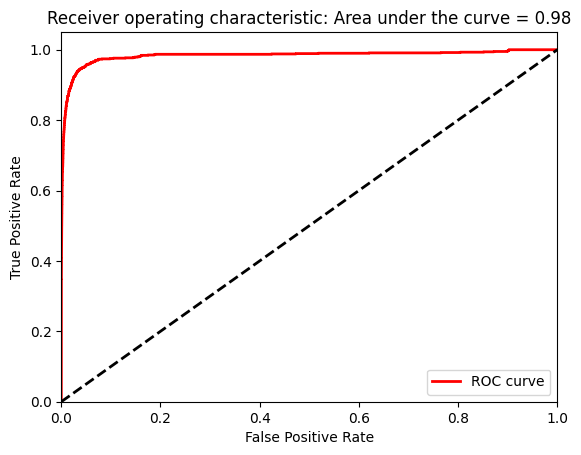

In [62]:
fpr, tpr, thresholds = roc_curve(preds_ada['trueLabel'],preds_ada['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Comment on the Base models Performace
We have implemented the different model such as logistic regression, SVM,RF,adaboot. Maily to evalute the perfrmace of the models I have consider the accuarcy of model and the f1_score. f1_score gives the overall infomation about the precision  and recall when f1_score is high ultimately we have good precisiona nd recall.

From the above implemetation the randomforest has performed well on the dataset with imputation.

Remark: upon decreasing the n_estimator in the adaboot the perfomance of model decreases.

# Implementation using Deep Learning with median imputation

# First define the models
The shape of data is 60000,163 as we have droped the 7 columns which had 70% null values

In [25]:
def B_model1():
    model = models.Sequential()
    model.add(layers.Dense(60, input_shape=(163,), activation='relu'))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    



def BN_model():
    model=models.Sequential()
    model.add(layers.Dense(60, input_shape=(163,), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(30,activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    # compile the model
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model
    


In [26]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(data_trmedian_x,data_trmedian_y):
    train_x_fold, x_cv_fold = data_trmedian_x.iloc[train_index,:], data_trmedian_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = data_trmedian_y.iloc[train_index], data_trmedian_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    base_model=B_model1()
    high_model=BN_model()

    
    history1=base_model.fit(train_x_fold,train_y_fold,batch_size=1000,epochs=60,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=high_model.fit(train_x_fold,train_y_fold,batch_size=1000,epochs=60,validation_data=(x_cv_fold,y_cv_fold),verbose=0)


In [27]:
# create the datafraem to store the model history
df_base=pd.DataFrame(history1.history)
df_base["epochs"]=history1.epoch


df_high=pd.DataFrame(history2.history)
df_high["epochs"]=history2.epoch

# Performance Evalution

In [30]:
# predcition on the test data and the 0.5 theshold can be chnaged 
predict_base=base_model.predict(data_temedian_x)
predict_base=predict_base>0.5
predict_high_BN=high_model.predict(data_temedian_x)
predict_high_BN=predict_high_BN>0.5

500/500 [==============================] - 1s 1ms/step


In [31]:
# print the classification report and it for B_model
print(classification_report(data_temedian_y,predict_base))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.84      0.63      0.72       375

    accuracy                           0.99     16000
   macro avg       0.91      0.82      0.86     16000
weighted avg       0.99      0.99      0.99     16000



In [32]:
# classification report for the model BN_model
print(classification_report(data_temedian_y,predict_high_BN))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.96      0.45      0.61       375

    accuracy                           0.99     16000
   macro avg       0.97      0.73      0.80     16000
weighted avg       0.99      0.99      0.98     16000



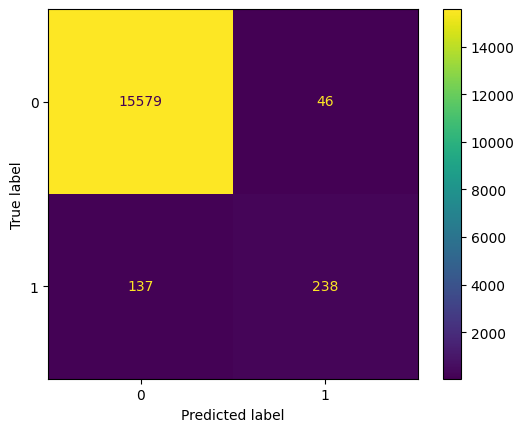

In [33]:
# confusion matrix for the B_model
cm=confusion_matrix(data_temedian_y,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

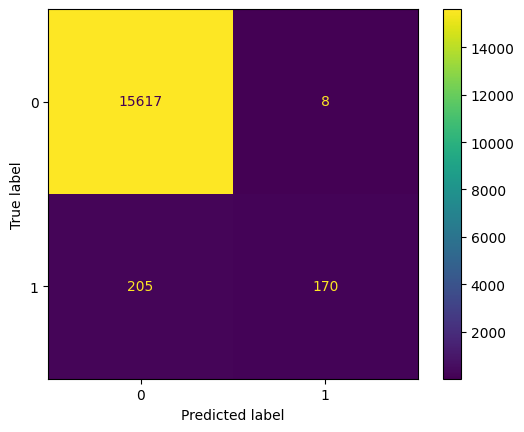

In [34]:
# confusion matrix for the B_model
cm=confusion_matrix(data_temedian_y,predict_high_BN)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

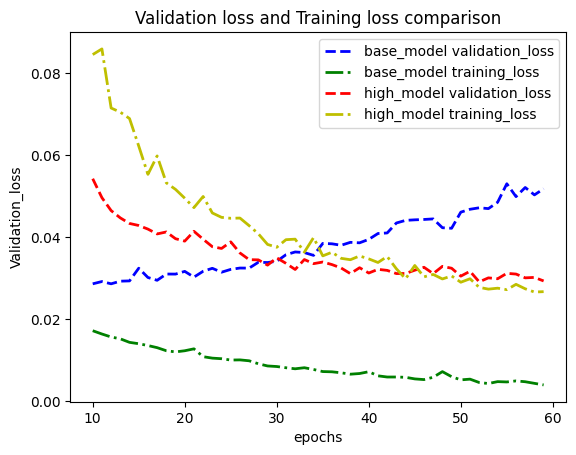

In [40]:
compare_val_loss(df_base,df_high)

Base model:

considering the validation loss and training curve for the base model, it is seen that they oppoiste o each other. When the training loss is decreasing the validation loss is increasing. Which is an indicator that model is not perfomrating good and it overfitts the data. The reason not enough complexity of model.

High_model:

the high model is performing well compare to the base model, also the both validation losss curve and trainining loss curve  is coincide each other. Which shows that the training loss and validation loss decreasing over the numver of epochs.

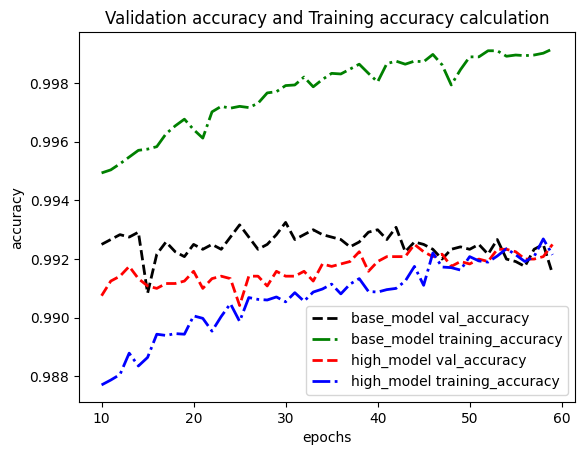

In [41]:
compare_accuracy_curve(df_base,df_high)

# Comment on the overall performance of this approach
The performace of any model can't be calculated based on the single parameter such as only considering the accuarcy, we must cinsider the other factors according the problem statement such as f1-score,precision, recall,ROC.

Mainly the f1-score and accuracy is important these are the parameters which shows that how the dataset is been classified.

The base model has shown the good f1-score and accuarcy wrt high model but it seems it is overfitting on that data. We can try implementation of different models.

## Deep learning approach on Median Imputated dataset with Batch Normalization

In [42]:
def B_model1():
    model = models.Sequential()
    model.add(layers.Dense(60, input_shape=(163,), activation='relu'))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    


def BN_model1():
    model=models.Sequential()
    model.add(layers.Dense(60, input_shape=(163,), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(30,activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    # compile the model
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model
    


In [53]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(data_trmedian_x,data_trmedian_y):
    train_x_fold, x_cv_fold = data_trmedian_x.iloc[train_index,:], data_trmedian_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = data_trmedian_y.iloc[train_index], data_trmedian_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    model_1=B_model1()
    model_2=BN_model()

    
    history1=model_1.fit(train_x_fold,train_y_fold,batch_size=1000,epochs=60,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=model_2.fit(train_x_fold,train_y_fold,batch_size=1000,epochs=60,validation_data=(x_cv_fold,y_cv_fold),verbose=0)






In [127]:
# save the weights of best model
model_2.save("Best_model_deep_learning_withMedian_imputation.h5")

In [54]:
# save the model history in the dataframe
df1=pd.DataFrame(history1.history)
df1['epochs']=history1.epoch

df2=pd.DataFrame(history2.history)
df2['epochs']=history2.epoch



In [55]:
# predcition on the test data with 0.5 as threshold 
predict_base=model_1.predict(data_temedian_x)
predict_base=predict_base>0.5
predict_base_BN=model_2.predict(data_temedian_x)
predict_base_BN=predict_base_BN>0.5

500/500 [==============================] - 1s 2ms/step


In [56]:
# print the classification report and it for B_model
print(classification_report(data_temedian_y,predict_base))


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     15625
         1.0       0.76      0.69      0.72       375

    accuracy                           0.99     16000
   macro avg       0.87      0.84      0.86     16000
weighted avg       0.99      0.99      0.99     16000



In [57]:

# classification report for the model BN_model
print(classification_report(data_temedian_y,predict_base_BN))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.94      0.45      0.61       375

    accuracy                           0.99     16000
   macro avg       0.96      0.73      0.80     16000
weighted avg       0.99      0.99      0.98     16000



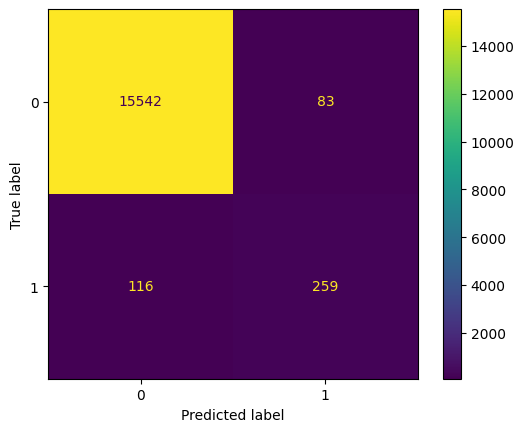

In [58]:
# confusion matrix for the B_model
cm=confusion_matrix(data_temedian_y,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

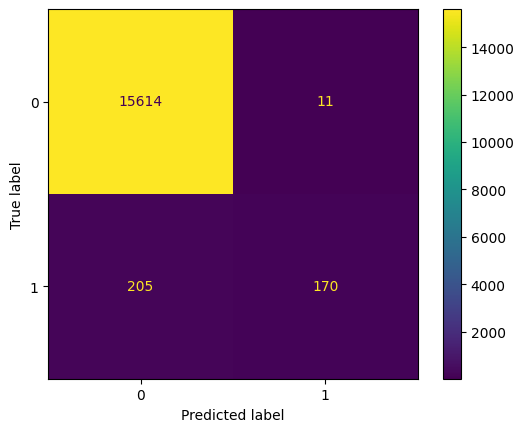

In [59]:
# confusion matrix for the BN_model
cm=confusion_matrix(data_temedian_y,predict_base_BN)
disp_=ConfusionMatrixDisplay(cm)
disp_.plot()

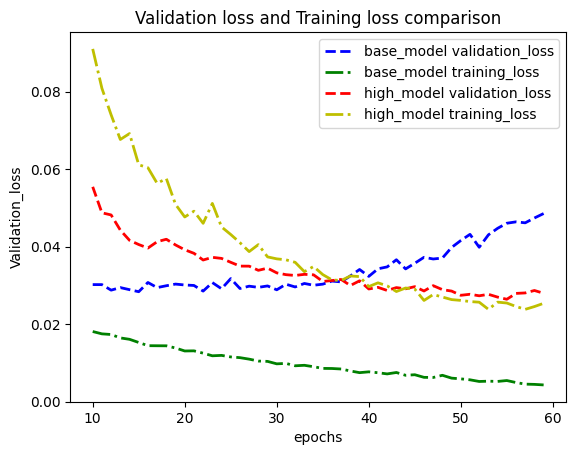

In [124]:
# plot the validation and training loss curves for different models
compare_val_loss(df1,df2)

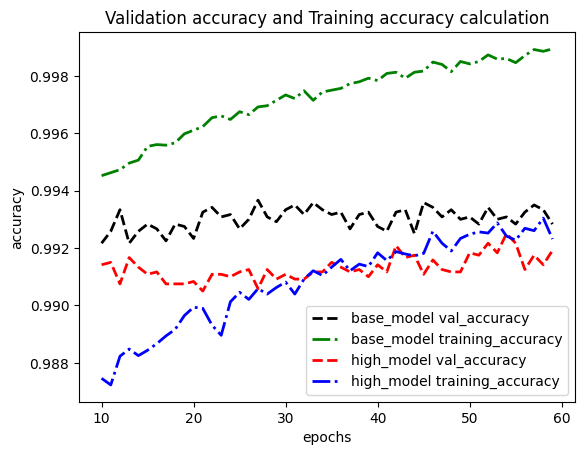

In [61]:
compare_accuracy_curve(df1,df2)

In [95]:
def Model_R():
    model = models.Sequential()
    model.add(layers.Dense(60,kernel_initializer="uniform",kernel_regularizer=regularizers.l1(0.01), input_shape=(163,), activation='relu'))
    model.add(layers.Dense(30, activation='relu',kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    
def Model_BR():
    model=models.Sequential()
    model.add(layers.Dense(60,kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.001), input_shape=(163,), activation='relu'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(30,kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    #model.add(layers.BatchNormalization())
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    # compile the model
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model


In [96]:
# Training the model using training data and validating it performance using validation dataset
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(data_trmedian_x,data_trmedian_y):
    train_x_fold, x_cv_fold = data_trmedian_x.iloc[train_index,:], data_trmedian_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = data_trmedian_y.iloc[train_index], data_trmedian_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    model_1=Model_R()
    model_2=Model_BR()

    
    history1=model_1.fit(train_x_fold,train_y_fold,batch_size=1000,epochs=60,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=model_2.fit(train_x_fold,train_y_fold,batch_size=1000,epochs=60,validation_data=(x_cv_fold,y_cv_fold),verbose=0)



df_RM=pd.DataFrame(history1.history)
df_RM["epochs"]=history1.epoch


df_BRM=pd.DataFrame(history2.history)
df_BRM["epochs"]=history2.epoch



    

In [87]:
# predcition on the test data with 0.5 as threshold 
predict_base=model_1.predict(data_temedian_x)
predict_base=predict_base>0.6
predict_base_BN=model_2.predict(data_temedian_x)
predict_base_BN=predict_base_BN>0.4

500/500 [==============================] - 1s 2ms/step


In [88]:
# print the classification report and it for B_model
print(classification_report(data_temedian_y,predict_base))


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     15625
         1.0       0.00      0.00      0.00       375

    accuracy                           0.98     16000
   macro avg       0.49      0.50      0.49     16000
weighted avg       0.95      0.98      0.96     16000



C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:

# classification report for the model BN_model
print(classification_report(data_temedian_y,predict_base_BN))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.77      0.44      0.56       375

    accuracy                           0.98     16000
   macro avg       0.88      0.72      0.78     16000
weighted avg       0.98      0.98      0.98     16000



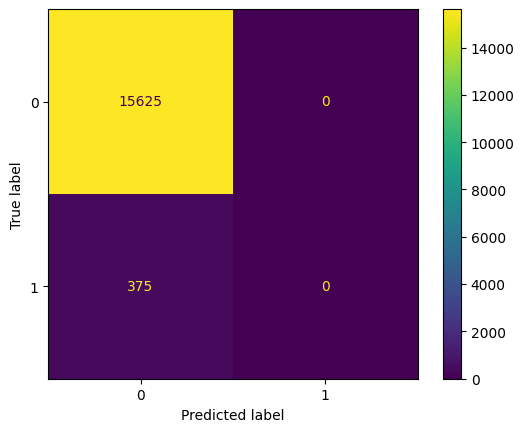

In [90]:
# confusion matrix for the BN_model
cm=confusion_matrix(data_temedian_y,predict_base)
disp_=ConfusionMatrixDisplay(cm)
disp_.plot()

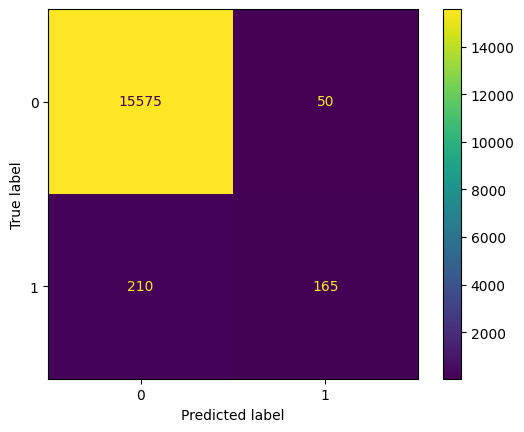

In [91]:
# confusion matrix for the BN_model
cm=confusion_matrix(data_temedian_y,predict_base_BN)
disp_=ConfusionMatrixDisplay(cm)
disp_.plot()

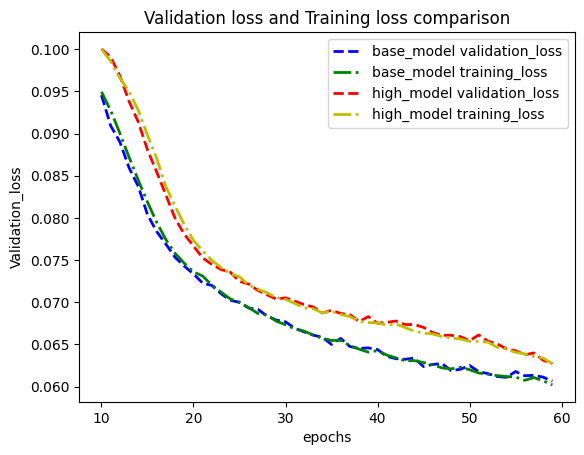

In [92]:
compare_val_loss(df_BRM,df_RM)

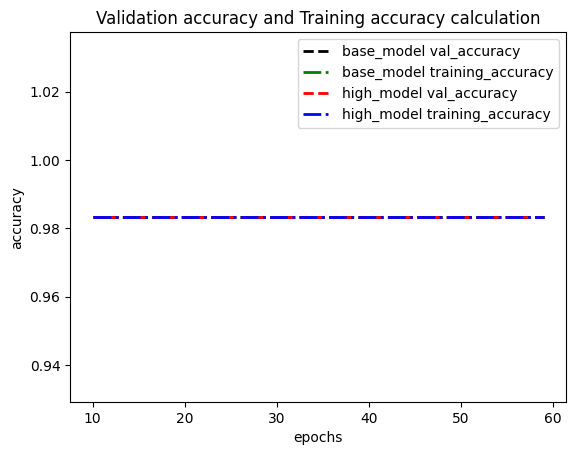

In [94]:
compare_accuracy_curve(df_BRM,df_RM)

# Final Comments on the Approaches

I have tried to implement the model in three different approaches as following.

# Approach 1: Implementation using the Base model and dropping all the null values (Included in Approach_First.ipynb)
# Approach 2: Implemtation using the Base model along with Principle Componnect Analysis and dropping all the null values (included in Approach_Second.ipynb)
# Approach 3: Implementation of Deep Learning Models using the Median Imputation.



# Approach 1
In this Notebook I have implemented different Base Model methods such as Logistic Regression, Supper Vesctor Machine, Random Forest, AdaBoot. Considering the evalution parameters to compare the performances of different regression implementation, I have considered Classfication Report (precision, Recall and F1_score), Confusion Matric, precision recall curve and Receiver Oeprating Characteritics curve.

Based on this studies I have observed that Random Forest and AdaBoost has shown Best Performance.

![Getting Started](./Resultsregression.png)



![Getting Started](./RF.png)


![Getting Started](./Adaboost.png)


# Results of Deep Learning Approach

![Getting Started](./DeepLearning.png)



# Comparing the Results of this in Approach 1 Random Forest and Adaboost has good performance



# Approach 2

Looking at the PCA results it has been seen that reducing the diamension of Data hasn't performed well.

![Getting Started](./PCA.png)

# Approach 3

Using the Base model for the classification task, from the results we can say that the Random Forest has shown the good performance but it must be improved

![Getting Started](./REgression_median.png)










# From all these results I can say that most of time the base ML Models has performed well than the DL learning Approaches.